In [1]:
import numpy as np
import json 
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


# Before Start

Please download (more) samples from [OneDrive](https://1drv.ms/f/c/347c1b40c8c6e5ec/Ej5OQVE_APpOnNuP-ZXpnZcBnr_-ix5W-twQcYIJ-dvW2A?e=YcBSPF), and put them into `data` and `results` folders, respectively. The `results` is gotten with [inference.py](inference.py). 

# Metric 1: Mean Absolute Error

### Step 1: Normalize the dose by setting D97 to prescribed dose of PTV_High

We will do this normalization in validation and testing phase, please make sure your predicted dose normalized in the same way. 

In [2]:
plan_file_name = '0617-259694+imrt+MOS_33896'
PTVHighname = 'PTV'

data_path = f'data/{plan_file_name}.npz'
data_npz = np.load(data_path, allow_pickle=True)
data_dict = dict(data_npz)['arr_0'].item()

scale_dose_Dict = json.load(open('meta_files/PTV_DICT.json'))
ref_dose = data_dict['dose'] * data_dict['dose_scale']
ptv_highdose =  scale_dose_Dict['HNC_001']['PTV_High']['PDose']
norm_scale = ptv_highdose / (np.percentile(ref_dose[data_dict[PTVHighname].astype('bool')], 3) + 1e-5)
ref_dose = ref_dose * norm_scale


### Step 2: Calculate the error

Considering 1) Higher dose region is usually more important in clinical practice and 2) only dose within the body is of the interest, we mask out the regions with the 5 Gy isodose line and body mask. 

In [3]:
prediction = np.random.random(ref_dose.shape) * 10 # replace random matrix with your prediction

prediction = np.load(f'results/lightning/{plan_file_name}_pred.npy')

isodose_5Gy_mask = ((ref_dose > 5) | (prediction > 5)) & (data_dict['Body'] > 0) # the mask include the body AND the region where the dose/prediction is higher than 5Gy

diff = ref_dose - prediction

error = np.mean(np.abs(diff)[isodose_5Gy_mask > 0])

print (f'the MAE error is {error:.3f}')

### MAE for a batch of data (Metric 1 on challenge leaderboard)

Requirement: 

1. the 3D dose prediction for each plan should be stored with the format "{plan_file_name}_pred.npy", for example, '0617-259694+imrt+MOS_33896_pred.npy';

2. all the npy files of your prediction should be stored in one folder, like folder "results/lightning" of this [OneDrive link](https://1drv.ms/f/c/347c1b40c8c6e5ec/Ej5OQVE_APpOnNuP-ZXpnZcBOdhSXKoXukyyxecl5IKk1g?e=emSAkf). 

3. all the predictions of the evalution list (prevoided by organizer) should be included; missing item is not allowed. 

4. Download the example sanity_check_submission.zip file from this [OneDrive link](https://1drv.ms/f/c/347c1b40c8c6e5ec/Ej5OQVE_APpOnNuP-ZXpnZcBOdhSXKoXukyyxecl5IKk1g?e=emSAkf), which can be directly upload to "My Submissions" of the platform. You can update it with your own prediction but with the same format. There are only four samples needed for sanity check. 

5. When preparing the results for submission (Phase I, Phase II), all the *_pred.npy files should under one zip file. After unzipping, all the files should be unzipped and there is no folder included. One example about file structure can be found here: [OneDrive link](https://1drv.ms/f/c/347c1b40c8c6e5ec/Ej5OQVE_APpOnNuP-ZXpnZcBOdhSXKoXukyyxecl5IKk1g?e=emSAkf).

In [17]:

## ----------------------Phase 1: sanity check ------------------------

evaluation_list = ['HNC_001+9Ag+MOS_25934', 'HNC_001+A4Ac+MOS_25934', '0617-259694+2Ac+MOS_33896', '0617-259694+imrt+MOS_33896' ] #  defined by organizers
PTVHighname_list = [ 'PTVHighOPT', 'PTVHighOPT', 'PTV', 'PTV']  # provided by organizers, lung site is PTV, HNC site is PTVHighOPT
reference_data_folder = '../pretrainmodel/GDP-HMM_Challenge/lightning/data' # only accessable to organizers for Phase II and Phase III. 
prediction_folder = '../pretrainmodel/GDP-HMM_Challenge/lightning_update/results_dummy' 


# # ----------------------Phase 2: validation ------------------------
import pandas as pd
df = pd.read_csv('meta_files/meta_data.csv')
df = df.loc[df['phase'] == 'valid']
npz_paths = df['npz_path'].tolist()
evaluation_list = [path.split('/')[-1].split('.')[0] for path in npz_paths]

site_list = df['site'].tolist()
PTVHighname_list = [ 'PTVHighOPT' if site == 1 else 'PTV' for site in site_list ]  # provided by organizers, lung site is PTV, HNC site is PTVHighOPT
reference_data_folder = '../../data/GDP-HMM_Challenge/valid_withdose' # only accessable to organizers for Phase II and Phase III. 
prediction_folder = '../pretrainmodel/GDP-HMM_Challenge/lightning_update/results_val' 

# ---------------------- common code for Phase 1 and 2 ----------------

MAE_list = []

for i in range(len(evaluation_list)):

    plan_file_name = evaluation_list[i]
    PTVHighname = PTVHighname_list[i]

    patient_id = plan_file_name.split('+')[0]

    data_path = f'{reference_data_folder}/{plan_file_name}.npz'
    data_npz = np.load(data_path, allow_pickle=True)
    data_dict = dict(data_npz)['arr_0'].item()
    
    scale_dose_Dict = json.load(open('meta_files/PTV_DICT.json'))
    ref_dose = data_dict['dose'] * data_dict['dose_scale']
    ptv_highdose =  scale_dose_Dict[patient_id]['PTV_High']['PDose']
    norm_scale = ptv_highdose / (np.percentile(ref_dose[data_dict[PTVHighname].astype('bool')], 3) + 1e-5)
    ref_dose = ref_dose * norm_scale

    prediction = np.load(f'{prediction_folder}/{plan_file_name}_pred.npy')

    isodose_5Gy_mask = ((ref_dose > 5) | (prediction > 5)) & (data_dict['Body'] > 0) # the mask include the body AND the region where the dose/prediction is higher than 5Gy

    isodose_ref_5Gy_mask = (ref_dose > 5) & (data_dict['Body'] > 0) # the mask include the body AND the region where the ref is higher than 5Gy

    diff = ref_dose - prediction

    error = np.sum(np.abs(diff)[isodose_5Gy_mask > 0]) / np.sum(isodose_ref_5Gy_mask)
    #print (error)
    MAE_list.append(error)

print ('the Metric 1 MAE displayed in leaderboard should be: ', np.mean(MAE_list))


the Metric 1 MAE displayed in leaderboard should be:  2.540400588086106


## Prepare the zip files for challenge submission 

We show the screenshot below how the files can be zipped (Phase I and Phase II), to meet the Requirement 5 above. 

```
$ cd {your_result_folder}

$ zip -r ../{any_name}.zip ./*_pred.npy
```

<p align="center">
  <img src='figs/sanity_check_zip.png' width="700px"/>
</p>

{}

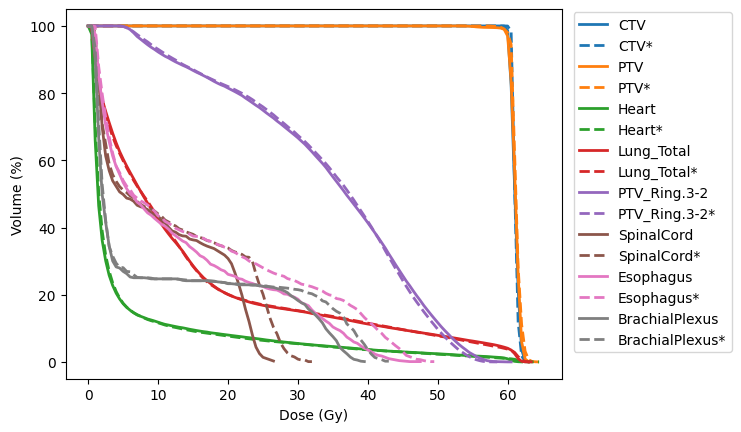

In [14]:
from toolkit import NPZ2DVH_2Dose

data_path = f'{reference_data_folder}/{plan_file_name}.npz'
data_npz = np.load(data_path, allow_pickle=True)
data_dict = dict(data_npz)['arr_0'].item()

prediction = np.load(f'{prediction_folder}/{plan_file_name}_pred.npy')

NPZ2DVH_2Dose(data_dict, needed_mask = ['CTV', 'PTV',  'Heart', 'Lung_Total', 'PTV_Ring.3-2', 'SpinalCord', 'Esophagus', 'BrachialPlexus'], additional_dose=prediction, ref_ptv_name = 'PTV', ref_dose = 60, bin_size = 0.5, with_plt = True, save_plt_path = None)

In [3]:
data_dict.keys()

dict_keys(['50per_Ring1.5-5', 'Body', 'Body_Ring0-3', 'BrachialPlexus', 'CTV', 'Esophagus', 'GTV', 'GreatVessels', 'Heart', 'LAD', 'Lung_Cntr', 'Lung_Ipsi', 'Lung_Total', 'PTV', 'PTV_Ring.3-2', 'SpinalCord', 'SpinalCord_05', 'Total Lung-GTV', 'Trachea', 'all_mask', 'img', 'dose', 'dose_scale', 'isVMAT', 'isocenter', 'angle_list', 'origin', 'spacing', 'direction', 'size', 'angle_plate', 'beam_plate'])

We show the examples visually that predicted with a very simple basline. Participants can also use the `save_mhd` function in the `toolkit.py` file. 

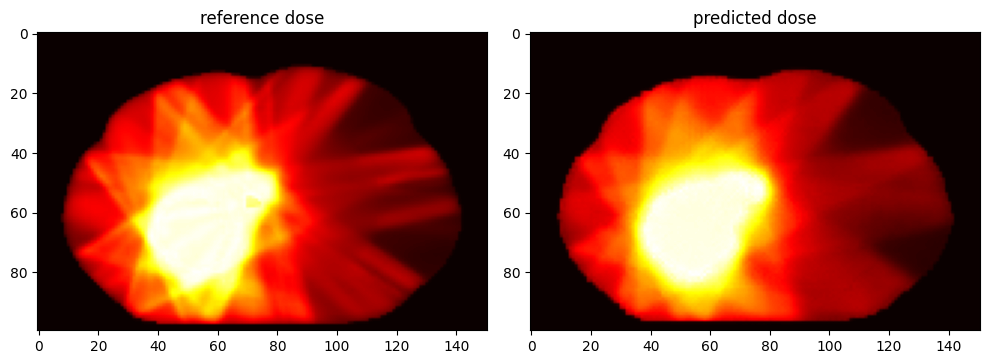

In [15]:
# visually check 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot on the first subplot
ax1.imshow(ref_dose[48], cmap='hot')
ax1.set_title('reference dose')

# Plot on the second subplot
ax2.imshow(prediction[48], cmap='hot')
ax2.set_title('predicted dose')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Metric 2: Plan quality of the derived deliverable plan

The plan quality will be evaluted by the organizer using the Eclipse planning system. The participants only need to submit their prediction or solution. The rationale and pipeline of how the deliverable plan being created and how the plan quality metric is calcuated are documented in Ref [1] of <a href="README.md" _target='blank'>README.md</a>. 